In [1]:
import itertools
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import DP as dp
import parameters as param
import process_edited as pce
import timeautoencoder as tae
import timediffusion as tdf


In [2]:
data     = 'Hurricane'
filename = f'/Users/fouadabiad/Projects/TimeAutoDiff/Dataset/Single-Sequence/Hurricane.csv'

# Read dataframe
print(filename)
real_df  = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1).iloc[0:2000,:]
real_df2 = real_df.iloc[0:2000,:]

# Pre-processing Data
threshold = 1
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
column_to_partition = 'Symbol'
#processed_data, time_info = dp.partition_multi_seq(real_df, threshold, column_to_partition);

processed_data= dp.splitData(real_df1, 24, threshold)
time_info     = dp.splitTimeData(real_df2, processed_data.shape[1]).to(device)


# commented out the following to make room for hyperparameter search
# Auto-encoder Training
n_epochs    = param.n_epochs
eps         = param.eps
weight_decay= param.weight_decay
lr          = param.lr
hidden_size = param.hidden_size
num_layers  = param.num_layers
batch_size  = param.batch_size
channels    = param.channels
min_beta    = param.min_beta
max_beta    = param.max_beta
emb_dim     = param.emb_dim
time_dim    = param.time_dim
lat_dim     = param.lat_dim
seq_col     = param.seq_col

# real_df1 = real_df1.drop(column_to_partition, axis=1)

# ds = tae.train_autoencoder(real_df1, processed_data, time_info.to(device), channels, hidden_size, num_layers, lr, weight_decay, n_epochs, \
#                            batch_size, threshold,  min_beta, max_beta, emb_dim, time_dim, lat_dim, device)

ds = tae.train_autoencoder(real_df1, processed_data, channels, hidden_size, num_layers, lr, weight_decay, n_epochs, batch_size, threshold, \
                           min_beta, max_beta, emb_dim, time_dim, lat_dim, device)


/Users/fouadabiad/Projects/TimeAutoDiff/Dataset/Single-Sequence/Hurricane.csv


/Users/fouadabiad/Projects/TimeAutoDiff/Model Code/DP.py:150: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  data = torch.tensor(temp_data)


Output()

In [ ]:
# Hyperparameter search

param_grid = {
    'lat_dim': [5, 7, 10],
    'hidden_size': [150, 200, 250],
    'lr': [1e-4, 5e-4],
    'num_layers': [1, 2],
    'emb_dim': [64, 128],
    'weight_decay': [1e-6, 1e-5],
    'batch_size': [32, 50]}

# Get all combinations of the parameter grid
param_combinations = list(itertools.product(*param_grid.values()))
param_names        = list(param_grid.keys())

best_loss   = float('inf')
best_params = None
all_results = []

# Loop through each parameter combination and run the training
for i, combo in enumerate(param_combinations):
    print(f"\n{'='*30} Running Trial {i+1}/{len(param_combinations)} {'='*30}")

    # Create a dictionary of the current parameter settings
    current_params = dict(zip(param_names, combo))
    params_str     = ", ".join([f"{key}: {value}" for key, value in current_params.items()])
    print(f"Current Parameter Combination: {params_str}")

    # Set the parameters for this run
    n_epochs    = param.n_epochs
    eps         = param.eps
    channels    = param.channels # Assuming this is fixed
    min_beta    = param.min_beta   # Assuming this is fixed
    max_beta    = param.max_beta   # Assuming this is fixed
    time_dim    = param.time_dim   # Assuming this is fixed
    seq_col     = param.seq_col   # Assuming this is fixed

    lat_dim     = current_params['lat_dim']
    hidden_size = current_params['hidden_size']
    lr          = current_params['lr']
    num_layers  = current_params['num_layers']
    emb_dim     = current_params['emb_dim']
    weight_decay= current_params['weight_decay']
    batch_size  = current_params['batch_size']

    try:
        ds = tae.train_autoencoder(real_df1, processed_data, channels, hidden_size, num_layers, lr, weight_decay, n_epochs,
                                   batch_size, threshold, min_beta, max_beta, emb_dim, time_dim, lat_dim, device)
        reconstruction_loss_history = ds[4]
        final_reconstruction_loss = reconstruction_loss_history[-1] # Get the final loss

        all_results.append({'params': current_params, 'final_reconstruction_loss': final_reconstruction_loss, 'all_losses': reconstruction_loss_history})
        print(f"Trial {i+1} finished. Final Reconstruction Loss: {final_reconstruction_loss:.4f}")

        if final_reconstruction_loss < best_loss:
            best_loss = final_reconstruction_loss
            best_params = current_params

    except Exception as e:
        print(f"Error occurred during Trial {i+1}: {e}")

print("\n{'='*50} Parameter tuning finished {'='*50}")
print("\n{'='*50} Best Parameter Combination {'='*50}")
if best_params:
    print(f"Best Parameters: {best_params}")
    print(f"Best Final Reconstruction Loss: {best_loss:.4f}")
else:
    print("No successful trials to determine the best parameters.")

# Optional: Print the final loss for all trials
print("\n{'='*50} All Trial Results {'='*50}")
for result in all_results:
    print(f"Parameters: {result['params']}, Final Reconstruction Loss: {result['final_reconstruction_loss']:.4f}")

Output()


============================== Running Trial 1/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 1 finished. Final Reconstruction Loss: 0.8827

============================== Running Trial 2/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 2 finished. Final Reconstruction Loss: 0.5619

============================== Running Trial 3/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 3 finished. Final Reconstruction Loss: 1.0074

============================== Running Trial 4/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 4 finished. Final Reconstruction Loss: 1.0033

============================== Running Trial 5/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 5 finished. Final Reconstruction Loss: 0.7371

============================== Running Trial 6/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 6 finished. Final Reconstruction Loss: 0.6432

============================== Running Trial 7/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 7 finished. Final Reconstruction Loss: 0.6576

============================== Running Trial 8/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 8 finished. Final Reconstruction Loss: 0.9042

============================== Running Trial 9/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 9 finished. Final Reconstruction Loss: 0.9689

============================== Running Trial 10/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 10 finished. Final Reconstruction Loss: 0.9898

============================== Running Trial 11/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 11 finished. Final Reconstruction Loss: 0.8059

============================== Running Trial 12/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 12 finished. Final Reconstruction Loss: 0.8553

============================== Running Trial 13/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 13 finished. Final Reconstruction Loss: 0.6792

============================== Running Trial 14/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 14 finished. Final Reconstruction Loss: 0.9340

============================== Running Trial 15/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 15 finished. Final Reconstruction Loss: 0.7630

============================== Running Trial 16/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 16 finished. Final Reconstruction Loss: 0.9912

============================== Running Trial 17/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 17 finished. Final Reconstruction Loss: 0.0141

============================== Running Trial 18/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 18 finished. Final Reconstruction Loss: 0.0262

============================== Running Trial 19/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 19 finished. Final Reconstruction Loss: 0.0301

============================== Running Trial 20/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 20 finished. Final Reconstruction Loss: 0.0132

============================== Running Trial 21/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 21 finished. Final Reconstruction Loss: 0.0136

============================== Running Trial 22/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 22 finished. Final Reconstruction Loss: 0.0105

============================== Running Trial 23/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 23 finished. Final Reconstruction Loss: 0.0102

============================== Running Trial 24/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 24 finished. Final Reconstruction Loss: 0.0174

============================== Running Trial 25/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 25 finished. Final Reconstruction Loss: 0.0752

============================== Running Trial 26/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 26 finished. Final Reconstruction Loss: 0.0130

============================== Running Trial 27/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 27 finished. Final Reconstruction Loss: 0.0457

============================== Running Trial 28/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 28 finished. Final Reconstruction Loss: 0.0100

============================== Running Trial 29/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 29 finished. Final Reconstruction Loss: 0.0137

============================== Running Trial 30/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 30 finished. Final Reconstruction Loss: 0.0235

============================== Running Trial 31/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 31 finished. Final Reconstruction Loss: 0.1596

============================== Running Trial 32/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 32 finished. Final Reconstruction Loss: 0.0145

============================== Running Trial 33/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 33 finished. Final Reconstruction Loss: 0.7377

============================== Running Trial 34/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 34 finished. Final Reconstruction Loss: 0.7232

============================== Running Trial 35/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 35 finished. Final Reconstruction Loss: 0.6118

============================== Running Trial 36/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 36 finished. Final Reconstruction Loss: 0.5944

============================== Running Trial 37/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 37 finished. Final Reconstruction Loss: 0.4641

============================== Running Trial 38/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 38 finished. Final Reconstruction Loss: 0.4390

============================== Running Trial 39/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 39 finished. Final Reconstruction Loss: 0.4460

============================== Running Trial 40/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 40 finished. Final Reconstruction Loss: 0.3662

============================== Running Trial 41/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 41 finished. Final Reconstruction Loss: 0.8142

============================== Running Trial 42/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 42 finished. Final Reconstruction Loss: 0.6092

============================== Running Trial 43/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 43 finished. Final Reconstruction Loss: 0.7107

============================== Running Trial 44/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 44 finished. Final Reconstruction Loss: 0.5657

============================== Running Trial 45/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 45 finished. Final Reconstruction Loss: 0.5475

============================== Running Trial 46/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 46 finished. Final Reconstruction Loss: 0.4332

============================== Running Trial 47/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 47 finished. Final Reconstruction Loss: 0.5774

============================== Running Trial 48/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 48 finished. Final Reconstruction Loss: 0.5813

============================== Running Trial 49/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 49 finished. Final Reconstruction Loss: 0.0120

============================== Running Trial 50/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 50 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 51/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 51 finished. Final Reconstruction Loss: 0.0098

============================== Running Trial 52/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 52 finished. Final Reconstruction Loss: 0.0123

============================== Running Trial 53/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 53 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 54/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 54 finished. Final Reconstruction Loss: 0.0084

============================== Running Trial 55/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 55 finished. Final Reconstruction Loss: 0.0124

============================== Running Trial 56/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 56 finished. Final Reconstruction Loss: 0.0046

============================== Running Trial 57/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 57 finished. Final Reconstruction Loss: 0.0153

============================== Running Trial 58/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 58 finished. Final Reconstruction Loss: 0.0106

============================== Running Trial 59/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 59 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 60/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 60 finished. Final Reconstruction Loss: 0.0132

============================== Running Trial 61/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 61 finished. Final Reconstruction Loss: 0.0117

============================== Running Trial 62/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 62 finished. Final Reconstruction Loss: 0.0141

============================== Running Trial 63/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 63 finished. Final Reconstruction Loss: 0.0108

============================== Running Trial 64/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 64 finished. Final Reconstruction Loss: 0.0126

============================== Running Trial 65/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 65 finished. Final Reconstruction Loss: 0.5631

============================== Running Trial 66/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 66 finished. Final Reconstruction Loss: 0.4672

============================== Running Trial 67/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 67 finished. Final Reconstruction Loss: 0.7808

============================== Running Trial 68/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 68 finished. Final Reconstruction Loss: 0.5912

============================== Running Trial 69/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 69 finished. Final Reconstruction Loss: 0.4200

============================== Running Trial 70/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 70 finished. Final Reconstruction Loss: 0.3005

============================== Running Trial 71/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 71 finished. Final Reconstruction Loss: 0.6045

============================== Running Trial 72/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 72 finished. Final Reconstruction Loss: 0.1513

============================== Running Trial 73/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 73 finished. Final Reconstruction Loss: 0.4094

============================== Running Trial 74/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 74 finished. Final Reconstruction Loss: 0.4472

============================== Running Trial 75/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 75 finished. Final Reconstruction Loss: 0.5579

============================== Running Trial 76/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 76 finished. Final Reconstruction Loss: 0.4612

============================== Running Trial 77/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 77 finished. Final Reconstruction Loss: 0.1789

============================== Running Trial 78/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 78 finished. Final Reconstruction Loss: 0.1864

============================== Running Trial 79/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 79 finished. Final Reconstruction Loss: 0.2576

============================== Running Trial 80/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 80 finished. Final Reconstruction Loss: 0.4255

============================== Running Trial 81/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 81 finished. Final Reconstruction Loss: 0.0122

============================== Running Trial 82/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 82 finished. Final Reconstruction Loss: 0.0119

============================== Running Trial 83/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 83 finished. Final Reconstruction Loss: 0.0130

============================== Running Trial 84/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 84 finished. Final Reconstruction Loss: 0.0096

============================== Running Trial 85/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 85 finished. Final Reconstruction Loss: 0.0164

============================== Running Trial 86/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 86 finished. Final Reconstruction Loss: 0.0083

============================== Running Trial 87/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 87 finished. Final Reconstruction Loss: 0.0072

============================== Running Trial 88/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 88 finished. Final Reconstruction Loss: 0.0136

============================== Running Trial 89/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 89 finished. Final Reconstruction Loss: 0.0146

============================== Running Trial 90/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 90 finished. Final Reconstruction Loss: 0.0180

============================== Running Trial 91/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 91 finished. Final Reconstruction Loss: 0.0076

============================== Running Trial 92/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 92 finished. Final Reconstruction Loss: 0.0099

============================== Running Trial 93/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 93 finished. Final Reconstruction Loss: 0.0124

============================== Running Trial 94/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 94 finished. Final Reconstruction Loss: 0.0093

============================== Running Trial 95/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 95 finished. Final Reconstruction Loss: 0.0149

============================== Running Trial 96/288 ==============================
Current Parameter Combination: lat_dim: 5, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 96 finished. Final Reconstruction Loss: 0.0115

============================== Running Trial 97/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 97 finished. Final Reconstruction Loss: 0.9141

============================== Running Trial 98/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 98 finished. Final Reconstruction Loss: 0.8228

============================== Running Trial 99/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 99 finished. Final Reconstruction Loss: 0.9305

============================== Running Trial 100/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 100 finished. Final Reconstruction Loss: 0.9414

============================== Running Trial 101/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 101 finished. Final Reconstruction Loss: 0.8933

============================== Running Trial 102/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 102 finished. Final Reconstruction Loss: 0.5429

============================== Running Trial 103/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 103 finished. Final Reconstruction Loss: 0.3320

============================== Running Trial 104/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 104 finished. Final Reconstruction Loss: 0.7035

============================== Running Trial 105/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 105 finished. Final Reconstruction Loss: 1.0188

============================== Running Trial 106/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 106 finished. Final Reconstruction Loss: 0.9719

============================== Running Trial 107/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 107 finished. Final Reconstruction Loss: 1.0939

============================== Running Trial 108/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 108 finished. Final Reconstruction Loss: 0.7282

============================== Running Trial 109/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 109 finished. Final Reconstruction Loss: 0.6997

============================== Running Trial 110/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 110 finished. Final Reconstruction Loss: 0.6077

============================== Running Trial 111/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 111 finished. Final Reconstruction Loss: 0.9162

============================== Running Trial 112/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 112 finished. Final Reconstruction Loss: 0.8534

============================== Running Trial 113/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 113 finished. Final Reconstruction Loss: 0.0159

============================== Running Trial 114/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 114 finished. Final Reconstruction Loss: 0.0127

============================== Running Trial 115/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 115 finished. Final Reconstruction Loss: 0.0162

============================== Running Trial 116/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 116 finished. Final Reconstruction Loss: 0.0119

============================== Running Trial 117/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 117 finished. Final Reconstruction Loss: 0.0117

============================== Running Trial 118/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 118 finished. Final Reconstruction Loss: 0.0098

============================== Running Trial 119/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 119 finished. Final Reconstruction Loss: 0.0122

============================== Running Trial 120/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 120 finished. Final Reconstruction Loss: 0.0068

============================== Running Trial 121/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 121 finished. Final Reconstruction Loss: 0.0131

============================== Running Trial 122/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 122 finished. Final Reconstruction Loss: 0.0135

============================== Running Trial 123/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 123 finished. Final Reconstruction Loss: 0.0344

============================== Running Trial 124/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 124 finished. Final Reconstruction Loss: 0.0175

============================== Running Trial 125/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 125 finished. Final Reconstruction Loss: 0.0141

============================== Running Trial 126/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 126 finished. Final Reconstruction Loss: 0.0145

============================== Running Trial 127/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 127 finished. Final Reconstruction Loss: 0.0149

============================== Running Trial 128/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 128 finished. Final Reconstruction Loss: 0.0111

============================== Running Trial 129/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 129 finished. Final Reconstruction Loss: 0.6040

============================== Running Trial 130/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 130 finished. Final Reconstruction Loss: 0.6106

============================== Running Trial 131/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 131 finished. Final Reconstruction Loss: 0.6589

============================== Running Trial 132/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 132 finished. Final Reconstruction Loss: 0.3188

============================== Running Trial 133/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 133 finished. Final Reconstruction Loss: 0.3816

============================== Running Trial 134/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 134 finished. Final Reconstruction Loss: 0.0748

============================== Running Trial 135/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 135 finished. Final Reconstruction Loss: 0.3866

============================== Running Trial 136/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 136 finished. Final Reconstruction Loss: 0.2424

============================== Running Trial 137/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 137 finished. Final Reconstruction Loss: 0.5607

============================== Running Trial 138/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 138 finished. Final Reconstruction Loss: 0.5894

============================== Running Trial 139/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 139 finished. Final Reconstruction Loss: 0.7290

============================== Running Trial 140/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 140 finished. Final Reconstruction Loss: 0.8860

============================== Running Trial 141/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 141 finished. Final Reconstruction Loss: 0.4825

============================== Running Trial 142/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 142 finished. Final Reconstruction Loss: 0.4048

============================== Running Trial 143/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 143 finished. Final Reconstruction Loss: 0.1245

============================== Running Trial 144/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 144 finished. Final Reconstruction Loss: 0.4206

============================== Running Trial 145/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 145 finished. Final Reconstruction Loss: 0.0149

============================== Running Trial 146/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 146 finished. Final Reconstruction Loss: 0.0101

============================== Running Trial 147/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 147 finished. Final Reconstruction Loss: 0.0147

============================== Running Trial 148/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 148 finished. Final Reconstruction Loss: 0.0104

============================== Running Trial 149/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 149 finished. Final Reconstruction Loss: 0.0170

============================== Running Trial 150/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 150 finished. Final Reconstruction Loss: 0.0113

============================== Running Trial 151/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 151 finished. Final Reconstruction Loss: 0.0111

============================== Running Trial 152/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 152 finished. Final Reconstruction Loss: 0.0070

============================== Running Trial 153/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 153 finished. Final Reconstruction Loss: 0.0119

============================== Running Trial 154/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 154 finished. Final Reconstruction Loss: 0.0128

============================== Running Trial 155/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 155 finished. Final Reconstruction Loss: 0.0149

============================== Running Trial 156/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 156 finished. Final Reconstruction Loss: 0.0146

============================== Running Trial 157/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 157 finished. Final Reconstruction Loss: 0.0109

============================== Running Trial 158/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 158 finished. Final Reconstruction Loss: 0.0097

============================== Running Trial 159/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 159 finished. Final Reconstruction Loss: 0.0092

============================== Running Trial 160/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 160 finished. Final Reconstruction Loss: 0.0124

============================== Running Trial 161/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 161 finished. Final Reconstruction Loss: 0.6221

============================== Running Trial 162/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 162 finished. Final Reconstruction Loss: 0.5121

============================== Running Trial 163/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 163 finished. Final Reconstruction Loss: 0.6275

============================== Running Trial 164/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 164 finished. Final Reconstruction Loss: 0.4253

============================== Running Trial 165/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 165 finished. Final Reconstruction Loss: 0.1412

============================== Running Trial 166/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 166 finished. Final Reconstruction Loss: 0.2991

============================== Running Trial 167/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 167 finished. Final Reconstruction Loss: 0.1763

============================== Running Trial 168/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 168 finished. Final Reconstruction Loss: 0.2545

============================== Running Trial 169/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 169 finished. Final Reconstruction Loss: 0.4821

============================== Running Trial 170/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 170 finished. Final Reconstruction Loss: 0.3751

============================== Running Trial 171/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 171 finished. Final Reconstruction Loss: 0.4863

============================== Running Trial 172/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 172 finished. Final Reconstruction Loss: 0.3563

============================== Running Trial 173/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 173 finished. Final Reconstruction Loss: 0.3631

============================== Running Trial 174/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 174 finished. Final Reconstruction Loss: 0.3191

============================== Running Trial 175/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 175 finished. Final Reconstruction Loss: 0.4467

============================== Running Trial 176/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 176 finished. Final Reconstruction Loss: 0.1632

============================== Running Trial 177/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 177 finished. Final Reconstruction Loss: 0.0133

============================== Running Trial 178/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 178 finished. Final Reconstruction Loss: 0.0116

============================== Running Trial 179/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 179 finished. Final Reconstruction Loss: 0.0094

============================== Running Trial 180/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 180 finished. Final Reconstruction Loss: 0.0102

============================== Running Trial 181/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 181 finished. Final Reconstruction Loss: 0.0066

============================== Running Trial 182/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 182 finished. Final Reconstruction Loss: 0.0049

============================== Running Trial 183/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 183 finished. Final Reconstruction Loss: 0.0110

============================== Running Trial 184/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 184 finished. Final Reconstruction Loss: 0.0035

============================== Running Trial 185/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 185 finished. Final Reconstruction Loss: 0.0113

============================== Running Trial 186/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 186 finished. Final Reconstruction Loss: 0.0109

============================== Running Trial 187/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 187 finished. Final Reconstruction Loss: 0.0093

============================== Running Trial 188/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 188 finished. Final Reconstruction Loss: 0.0104

============================== Running Trial 189/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 189 finished. Final Reconstruction Loss: 0.0109

============================== Running Trial 190/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 190 finished. Final Reconstruction Loss: 0.0129

============================== Running Trial 191/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 191 finished. Final Reconstruction Loss: 0.0108

============================== Running Trial 192/288 ==============================
Current Parameter Combination: lat_dim: 7, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 192 finished. Final Reconstruction Loss: 0.0095

============================== Running Trial 193/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 193 finished. Final Reconstruction Loss: 0.9491

============================== Running Trial 194/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 194 finished. Final Reconstruction Loss: 0.6171

============================== Running Trial 195/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 195 finished. Final Reconstruction Loss: 0.6538

============================== Running Trial 196/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 196 finished. Final Reconstruction Loss: 0.7423

============================== Running Trial 197/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 197 finished. Final Reconstruction Loss: 0.2434

============================== Running Trial 198/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 198 finished. Final Reconstruction Loss: 0.3323

============================== Running Trial 199/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 199 finished. Final Reconstruction Loss: 0.3903

============================== Running Trial 200/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 200 finished. Final Reconstruction Loss: 0.8156

============================== Running Trial 201/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 201 finished. Final Reconstruction Loss: 1.0370

============================== Running Trial 202/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 202 finished. Final Reconstruction Loss: 0.5204

============================== Running Trial 203/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 203 finished. Final Reconstruction Loss: 0.9897

============================== Running Trial 204/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 204 finished. Final Reconstruction Loss: 0.7961

============================== Running Trial 205/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 205 finished. Final Reconstruction Loss: 1.0231

============================== Running Trial 206/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 206 finished. Final Reconstruction Loss: 0.8273

============================== Running Trial 207/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 207 finished. Final Reconstruction Loss: 0.7351

============================== Running Trial 208/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 208 finished. Final Reconstruction Loss: 0.6754

============================== Running Trial 209/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 209 finished. Final Reconstruction Loss: 0.0119

============================== Running Trial 210/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 210 finished. Final Reconstruction Loss: 0.0113

============================== Running Trial 211/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 211 finished. Final Reconstruction Loss: 0.0164

============================== Running Trial 212/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 212 finished. Final Reconstruction Loss: 0.0115

============================== Running Trial 213/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 213 finished. Final Reconstruction Loss: 0.0108

============================== Running Trial 214/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 214 finished. Final Reconstruction Loss: 0.0102

============================== Running Trial 215/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 215 finished. Final Reconstruction Loss: 0.0115

============================== Running Trial 216/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 216 finished. Final Reconstruction Loss: 0.0087

============================== Running Trial 217/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 217 finished. Final Reconstruction Loss: 0.0324

============================== Running Trial 218/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 218 finished. Final Reconstruction Loss: 0.0251

============================== Running Trial 219/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 219 finished. Final Reconstruction Loss: 0.0192

============================== Running Trial 220/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 220 finished. Final Reconstruction Loss: 0.0125

============================== Running Trial 221/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 221 finished. Final Reconstruction Loss: 0.0176

============================== Running Trial 222/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 222 finished. Final Reconstruction Loss: 0.0102

============================== Running Trial 223/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 223 finished. Final Reconstruction Loss: 0.0143

============================== Running Trial 224/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 150, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 224 finished. Final Reconstruction Loss: 0.1439

============================== Running Trial 225/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 225 finished. Final Reconstruction Loss: 0.6048

============================== Running Trial 226/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 226 finished. Final Reconstruction Loss: 0.7419

============================== Running Trial 227/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 227 finished. Final Reconstruction Loss: 0.5934

============================== Running Trial 228/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 228 finished. Final Reconstruction Loss: 0.6007

============================== Running Trial 229/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 229 finished. Final Reconstruction Loss: 0.3924

============================== Running Trial 230/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 230 finished. Final Reconstruction Loss: 0.0510

============================== Running Trial 231/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 231 finished. Final Reconstruction Loss: 0.5334

============================== Running Trial 232/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 232 finished. Final Reconstruction Loss: 0.1784

============================== Running Trial 233/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 233 finished. Final Reconstruction Loss: 0.7480

============================== Running Trial 234/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 234 finished. Final Reconstruction Loss: 0.4632

============================== Running Trial 235/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 235 finished. Final Reconstruction Loss: 0.6585

============================== Running Trial 236/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 236 finished. Final Reconstruction Loss: 0.6251

============================== Running Trial 237/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 237 finished. Final Reconstruction Loss: 0.5455

============================== Running Trial 238/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 238 finished. Final Reconstruction Loss: 0.1788

============================== Running Trial 239/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 239 finished. Final Reconstruction Loss: 0.6098

============================== Running Trial 240/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 240 finished. Final Reconstruction Loss: 0.6460

============================== Running Trial 241/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 241 finished. Final Reconstruction Loss: 0.0113

============================== Running Trial 242/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 242 finished. Final Reconstruction Loss: 0.0110

============================== Running Trial 243/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 243 finished. Final Reconstruction Loss: 0.0125

============================== Running Trial 244/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 244 finished. Final Reconstruction Loss: 0.0155

============================== Running Trial 245/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 245 finished. Final Reconstruction Loss: 0.0083

============================== Running Trial 246/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 246 finished. Final Reconstruction Loss: 0.0075

============================== Running Trial 247/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 247 finished. Final Reconstruction Loss: 0.0082

============================== Running Trial 248/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 248 finished. Final Reconstruction Loss: 0.0088

============================== Running Trial 249/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 249 finished. Final Reconstruction Loss: 0.0153

============================== Running Trial 250/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 250 finished. Final Reconstruction Loss: 0.0106

============================== Running Trial 251/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 251 finished. Final Reconstruction Loss: 0.0211

============================== Running Trial 252/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 252 finished. Final Reconstruction Loss: 0.0159

============================== Running Trial 253/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 253 finished. Final Reconstruction Loss: 0.0095

============================== Running Trial 254/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 254 finished. Final Reconstruction Loss: 0.0106

============================== Running Trial 255/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 255 finished. Final Reconstruction Loss: 0.0096

============================== Running Trial 256/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 200, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 256 finished. Final Reconstruction Loss: 0.0120

============================== Running Trial 257/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 257 finished. Final Reconstruction Loss: 0.5764

============================== Running Trial 258/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 258 finished. Final Reconstruction Loss: 0.4191

============================== Running Trial 259/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 259 finished. Final Reconstruction Loss: 0.4484

============================== Running Trial 260/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 260 finished. Final Reconstruction Loss: 0.5219

============================== Running Trial 261/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 261 finished. Final Reconstruction Loss: 0.0592

============================== Running Trial 262/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 262 finished. Final Reconstruction Loss: 0.0638

============================== Running Trial 263/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 263 finished. Final Reconstruction Loss: 0.1189

============================== Running Trial 264/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 264 finished. Final Reconstruction Loss: 0.0882

============================== Running Trial 265/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 265 finished. Final Reconstruction Loss: 0.2243

============================== Running Trial 266/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 266 finished. Final Reconstruction Loss: 0.2007

============================== Running Trial 267/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 267 finished. Final Reconstruction Loss: 0.5280

============================== Running Trial 268/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 268 finished. Final Reconstruction Loss: 0.4553

============================== Running Trial 269/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 269 finished. Final Reconstruction Loss: 0.3517

============================== Running Trial 270/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 270 finished. Final Reconstruction Loss: 0.3011

============================== Running Trial 271/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 271 finished. Final Reconstruction Loss: 0.3758

============================== Running Trial 272/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0001, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 272 finished. Final Reconstruction Loss: 0.2150

============================== Running Trial 273/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 273 finished. Final Reconstruction Loss: 0.0114

============================== Running Trial 274/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 274 finished. Final Reconstruction Loss: 0.0078

============================== Running Trial 275/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 275 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 276/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 276 finished. Final Reconstruction Loss: 0.0116

============================== Running Trial 277/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 277 finished. Final Reconstruction Loss: 0.0085

============================== Running Trial 278/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 278 finished. Final Reconstruction Loss: 0.0042

============================== Running Trial 279/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 279 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 280/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 1, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Output()

Trial 280 finished. Final Reconstruction Loss: 0.0083

============================== Running Trial 281/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 32


Output()

Trial 281 finished. Final Reconstruction Loss: 0.0117

============================== Running Trial 282/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-06, batch_size: 50


Output()

Trial 282 finished. Final Reconstruction Loss: 0.0094

============================== Running Trial 283/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 32


Output()

Trial 283 finished. Final Reconstruction Loss: 0.0132

============================== Running Trial 284/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 64, weight_decay: 1e-05, batch_size: 50


Output()

Trial 284 finished. Final Reconstruction Loss: 0.0118

============================== Running Trial 285/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 32


Output()

Trial 285 finished. Final Reconstruction Loss: 0.0124

============================== Running Trial 286/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-06, batch_size: 50


Output()

Trial 286 finished. Final Reconstruction Loss: 0.0101

============================== Running Trial 287/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 32


Output()

Trial 287 finished. Final Reconstruction Loss: 0.0115

============================== Running Trial 288/288 ==============================
Current Parameter Combination: lat_dim: 10, hidden_size: 250, lr: 0.0005, num_layers: 2, emb_dim: 128, weight_decay: 1e-05, batch_size: 50


Trial 288 finished. Final Reconstruction Loss: 0.0122

{'='*50} Parameter tuning finished {'='*50}

{'='*50} Best Parameter Combination {'='*50}
Best Parameters: {'lat_dim': 7, 'hidden_size': 250, 'lr': 0.0005, 'num_layers': 1, 'emb_dim': 128, 'weight_decay': 1e-05, 'batch_size': 50}
Best Final Reconstruction Loss: 0.0035

{'='*50} All Trial Results {'='*50}
Parameters: {'lat_dim': 5, 'hidden_size': 150, 'lr': 0.0001, 'num_layers': 1, 'emb_dim': 64, 'weight_decay': 1e-06, 'batch_size': 32}, Final Reconstruction Loss: 0.8827
Parameters: {'lat_dim': 5, 'hidden_size': 150, 'lr': 0.0001, 'num_layers': 1, 'emb_dim': 64, 'weight_decay': 1e-06, 'batch_size': 50}, Final Reconstruction Loss: 0.5619
Parameters: {'lat_dim': 5, 'hidden_size': 150, 'lr': 0.0001, 'num_layers': 1, 'emb_dim': 64, 'weight_decay': 1e-05, 'batch_size': 32}, Final Reconstruction Loss: 1.0074
Parameters: {'lat_dim': 5, 'hidden_size': 150, 'lr': 0.0001, 'num_layers': 1, 'emb_dim': 64, 'weight_decay': 1e-05, 'batch_size': 50

In [ ]:
# all_results

plt.figure(figsize=(12, 8))  # Adjust figure size as needed

for i, result in enumerate(all_results):
    params_str = ", ".join([f"{key}: {value:.1e}" for key, value in result['params'].items()])
    plt.plot(result['all_losses'], label=f"Trial {i+1} ({params_str})", alpha=0.6)

plt.title("Reconstruction loss for hyperparameter combinations")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
# plt.legend(fontsize='small')  # Adjust legend font size if needed
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'all_results' is not defined

<Figure size 1200x800 with 0 Axes>

(0.01204447471536696, 0.016086850315332413)

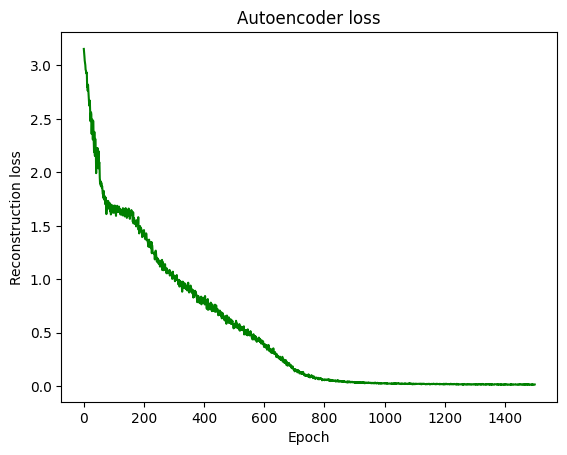

In [3]:
loss = ds[3]
reconstruction_loss = ds[4]

plt.plot(reconstruction_loss,  color='green')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
# plt.legend(['total', 'reconstruction', 'recon-disc'])
plt.title('Autoencoder loss')

np.min(reconstruction_loss), reconstruction_loss[-1]


In [ ]:
# Diffusion Training

latent_features= ds[1]
time           = time_info.to(device).float()

hidden_dim     = param.hidden_dim
num_layers     = param.num_layers_diff
diffusion_steps= param.diffusion_steps
n_epochs       = param.n_epochs_diff

num_classes    = len(latent_features)
diff, losses   = tdf.train_diffusion(latent_features, time, hidden_dim, num_layers, diffusion_steps, n_epochs)


# Sampling new data
latent_features= ds[1]
T              = latent_features.shape[1]
time_duration  = []
N, _, _        = latent_features.shape
t_grid         = torch.linspace(0, 1, T).view(1, -1, 1).to(device) # Note that we can use different sequence length here without any issues
samples        = tdf.sample(t_grid.repeat(N, 1, 1), latent_features.detach().to(device), diff, time)  


# Post-process the generated data 
gen_output  = ds[0].decoder(samples.to(device))  # Apply decoder to generated latent vector

data_size, seq_len, _ = latent_features.shape
synth_data  = pce.convert_to_tensor(real_df1, gen_output, threshold, data_size, seq_len)
_synth_data = pce.convert_to_table(real_df1, synth_data, threshold)


# Draw the plots for marginal of features : Real v.s. Synthetic
_real_data  = pce.convert_to_table(real_df1, processed_data, threshold)

# To see if you want to check latent vectors recovered well.
# B, L, K = latent_features.shape

# pd_reshaped = latent_features.reshape(B * L, K)
# sd_reshaped = samples.reshape(B * L, K)

# To see if you want to check real-data are recovered well.
B, L, K     = _synth_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)

real_df     = pd.DataFrame(pd_reshaped.numpy())
synth_df    = pd.DataFrame(sd_reshaped.numpy())

  0%|          | 0/600 [00:00<?, ?it/s]

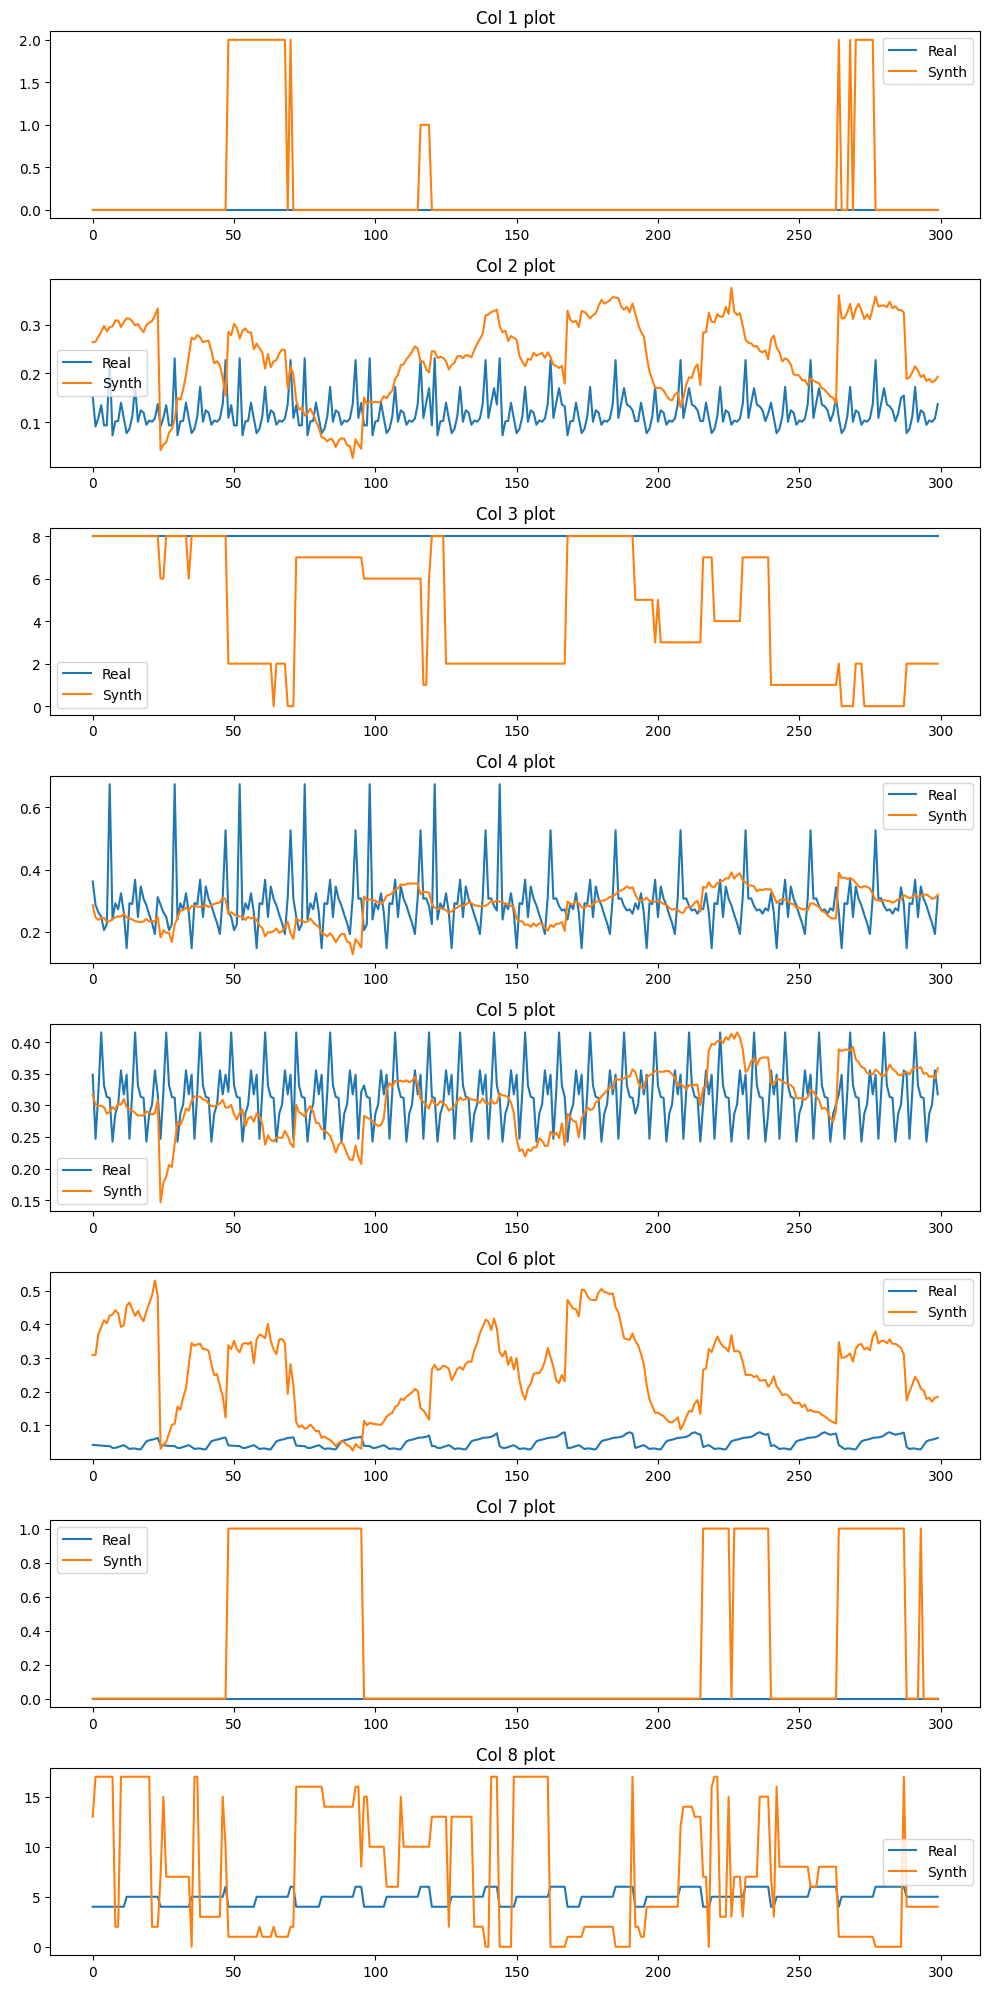

In [49]:
# np.mean(synth_df - real_df)

short_df       = real_df.copy().iloc[:300]
short_synth_df = synth_df.copy().iloc[:300]

fig, axes = plt.subplots(8, 1, figsize=(10, 20))

for i in range(8):
    axes[i].plot(short_df.index, short_df.iloc[:, i], label='Real')
    axes[i].plot(short_df.index, short_synth_df.iloc[:, i], label='Synth')
    axes[i].set_title(f"Col {i+1} plot")
    axes[i].legend()

plt.tight_layout()
plt.show()


In [5]:
parser = pce.DataFrameParser().fit(real_df1, threshold)
data   = parser.transform()
torch.tensor(data.astype('float32')).numpy()

array([[1.        , 0.        , 6.        , ..., 0.36178342, 0.3484531 ,
        0.04214609],
       [1.        , 0.        , 6.        , ..., 0.28659764, 0.24705194,
        0.04142576],
       [1.        , 0.        , 6.        , ..., 0.26242727, 0.321319  ,
        0.04070542],
       ...,
       [1.        , 0.        , 3.        , ..., 0.28851825, 0.34672305,
        0.16111593],
       [1.        , 0.        , 3.        , ..., 0.27295035, 0.39071777,
        0.16180271],
       [1.        , 0.        , 3.        , ..., 0.3134074 , 0.35545287,
        0.16338123]], dtype=float32)

In [6]:
data.shape

(2000, 8)

In [ ]:
data     = 'AirQuality'
filename = f'Data/{data}.csv'

# Read dataframe
print(filename)
real_df  = pd.read_csv(filename)
real_df1 = real_df.drop('date', axis=1).iloc[0:2000,:]

_synth_data = torch.load(f'Data/AirQuality_synth.pt')
_real_data  = torch.load(f'Data/AirQuality_real.pt')

B, L, K = _real_data.shape

sd_reshaped = _synth_data.reshape(B * L, K)
pd_reshaped = _real_data.reshape(B * L, K)


Data/AirQuality.csv


IndexError: index 8 is out of bounds for dimension 1 with size 8

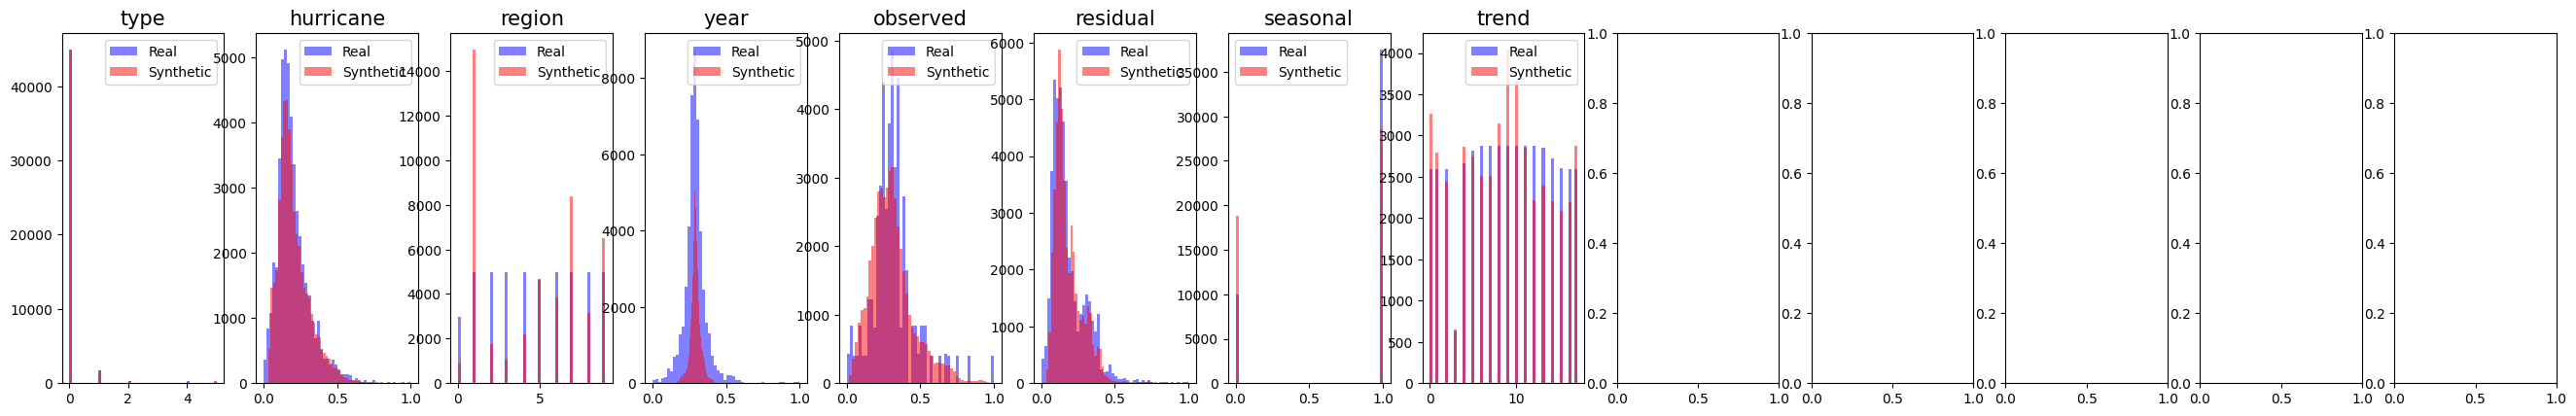

In [ ]:
parser   = pce.DataFrameParser().fit(real_df1, threshold)
col_name = parser.column_name()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=13, figsize=(33.1, 23.4/5))

for k in range(13):
    axes[k].hist(pd_reshaped[:, k].cpu().detach(), bins=50, color='blue', alpha=0.5, label='Real')
    axes[k].hist(sd_reshaped[:, k].cpu().detach(), bins=50, color='red', alpha=0.5, label='Synthetic')

    # Adding legends
    axes[k].legend()
    axes[k].set_title(col_name[k], fontsize=15)
    
# Adjust layout to prevent overlapping
plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Add space between histograms
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality
plt.show()

In [22]:
plt.savefig('hurricane.png', dpi=500)  # Adjust dpi as needed for quality

<Figure size 640x480 with 0 Axes>